In [1]:
import yfinance as yf
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, Bidirectional
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import Adam
import matplotlib.pyplot as plt



[*********************100%***********************]  1 of 1 completed


Rows: 1045 224 225
Lookback: 20
Shapes -> Xtr: (1025, 20, 8) ytr: (1025, 1)
Shapes -> Xv: (204, 20, 8) yv: (204, 1)
Shapes -> Xte: (205, 20, 8) yte: (205, 1)


c:\Users\Dell\AppData\Local\Programs\Python\Python313\Lib\site-packages\keras\src\layers\rnn\bidirectional.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/50
33/33 ━━━━━━━━━━━━━━━━━━━━ 9s 45ms/step - loss: 0.0446 - val_loss: 0.0122
Epoch 2/50
33/33 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - loss: 0.0089 - val_loss: 0.0141
Epoch 3/50
33/33 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - loss: 0.0073 - val_loss: 0.0129
Epoch 4/50
33/33 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - loss: 0.0062 - val_loss: 0.0115
Epoch 5/50
33/33 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - loss: 0.0061 - val_loss: 0.0081
Epoch 6/50
33/33 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - loss: 0.0050 - val_loss: 0.0074
Epoch 7/50
33/33 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - loss: 0.0051 - val_loss: 0.0074
Epoch 8/50
33/33 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - loss: 0.0042 - val_loss: 0.0059
Epoch 9/50
33/33 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - loss: 0.0044 - val_loss: 0.0041
Epoch 10/50
33/33 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - loss: 0.0041 - val_loss: 0.0093
Epoch 11/50
33/33 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - loss: 0.0039 - val_loss: 0.0033
Epoch 12/50
33/33 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - loss: 0.0

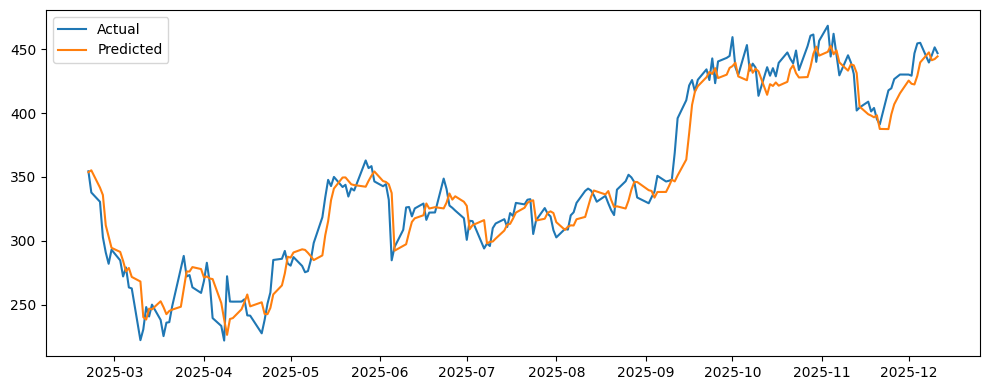

In [2]:

# 1) Load TSLA data from 2025-01-01
df = yf.download("TSLA", start="2020-01-01", end=None, auto_adjust=True)
df = df[['Open','High','Low','Close','Volume']].dropna()

# 2) Feature engineering
df['ret_1'] = df['Close'].pct_change()
df['vol_chg'] = df['Volume'].pct_change()
df['hl_spread'] = (df['High'] - df['Low']) / df['Close']
df = df.dropna()

features = ['Open','High','Low','Close','Volume','ret_1','vol_chg','hl_spread']
target = 'Close'

# 3) Train/val/test split (chronological)
split1 = int(len(df)*0.7)
split2 = int(len(df)*0.85)
train_df = df.iloc[:split1]
val_df   = df.iloc[split1:split2]
test_df  = df.iloc[split2:]

# Guard: ensure we have enough rows
if len(train_df) < 30:
    raise ValueError(f"Too few training rows ({len(train_df)}). "
                     "With a 2025-only start, consider extending history or reducing features that cause dropna.")

# 4) Scale with training-only fit
scaler_x = MinMaxScaler()
scaler_y = MinMaxScaler()
X_train = scaler_x.fit_transform(train_df[features])           # (n_train, n_features)
y_train = scaler_y.fit_transform(train_df[[target]])           # (n_train, 1)
X_val   = scaler_x.transform(val_df[features])
y_val   = scaler_y.transform(val_df[[target]])
X_test  = scaler_x.transform(test_df[features])
y_test  = scaler_y.transform(test_df[[target]])

# 5) Create sequences with adaptive lookback
def make_sequences(X, y, lookback=20):
    Xs, ys = [], []
    for i in range(lookback, len(X)):
        Xs.append(X[i-lookback:i])       # shape (lookback, features)
        ys.append(y[i])                  # shape (1,)
    return np.array(Xs), np.array(ys).reshape(-1,1)

# Adapt lookback so we don’t end up with empty sequences
lookback = 20
Xtr, ytr = make_sequences(X_train, y_train, lookback)
Xv, yv   = make_sequences(X_val, y_val, lookback)
Xte, yte = make_sequences(X_test, y_test, lookback)

# Debug prints
print("Rows:", len(train_df), len(val_df), len(test_df))
print("Lookback:", lookback)
print("Shapes -> Xtr:", Xtr.shape, "ytr:", ytr.shape)
print("Shapes -> Xv:", Xv.shape, "yv:", yv.shape)
print("Shapes -> Xte:", Xte.shape, "yte:", yte.shape)

# Guards: ensure non-empty sequences with correct ranks
for name, X_, y_ in [("train", Xtr, ytr), ("val", Xv, yv), ("test", Xte, yte)]:
    if X_.ndim != 3 or y_.ndim != 2 or len(X_) == 0:
        raise ValueError(f"{name} sequences invalid. Got X{X_.shape}, y{y_.shape}. "
                         "Reduce lookback or extend data range.")

# 6) Build LSTM
model = Sequential([
    Bidirectional(LSTM(32, return_sequences=True), input_shape=(lookback, Xtr.shape[-1])),
    Dropout(0.2),
    Bidirectional(LSTM(32)),
    Dropout(0.2),
    Dense(32, activation='relu'),
    Dense(1)
])


model.compile(optimizer="Adam", loss='mse')



# 7) Train
es = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
history = model.fit(
    Xtr, ytr,
    validation_data=(Xv, yv),
    epochs=50,
    batch_size=32,
    callbacks=[es],
    verbose=1
)

# 8) Evaluate
pred_scaled = model.predict(Xte)
pred = scaler_y.inverse_transform(pred_scaled)
y_true = scaler_y.inverse_transform(yte)

# 9) Metrics (RMSE correctly computed)
mae = mean_absolute_error(y_true, pred)
rmse = mean_squared_error(y_true, pred,)
print(f"Test MAE: {mae:.2f}, RMSE: {rmse:.2f}")

# 10) Plot aligned with sequence shortening
# Test sequences start at test_df.index[lookback:]
idx = test_df.index[lookback:]
# Guard: align lengths
n = min(len(idx), len(y_true), len(pred))
plt.figure(figsize=(10,4))
plt.plot(idx[:n], y_true[:n].ravel(), label='Actual')
plt.plot(idx[:n], pred[:n].ravel(), label='Predicted')
plt.legend()
plt.tight_layout()
plt.show()